# Homework 3
Ivy (Xinyue) Liu, xl438

## 1. Autoencoder

In [114]:
import warnings
warnings.filterwarnings("ignore")
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Embedding, LSTM, Conv1D, GlobalMaxPooling1D
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.utils import to_categorical
from keras.models import Sequential
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
import pandas as pd
import tensorflow as tf
import cv2
import preprocessor
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
import sklearn

In [2]:
# load fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# Rescale images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
# Convolutional Autoencoder
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
# Train the model
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 86s 1ms/step - loss: 0.3745 - val_loss: 0.3321
Epoch 2/5
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3221 - val_loss: 0.3161
Epoch 3/5
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3128 - val_loss: 0.3127
Epoch 4/5
60000/60000 [==============================] - 85s 1ms/step - loss: 0.3070 - val_loss: 0.3035
Epoch 5/5
60000/60000 [==============================] - 85s 1ms/step - loss: 0.3036 - val_loss: 0.3079


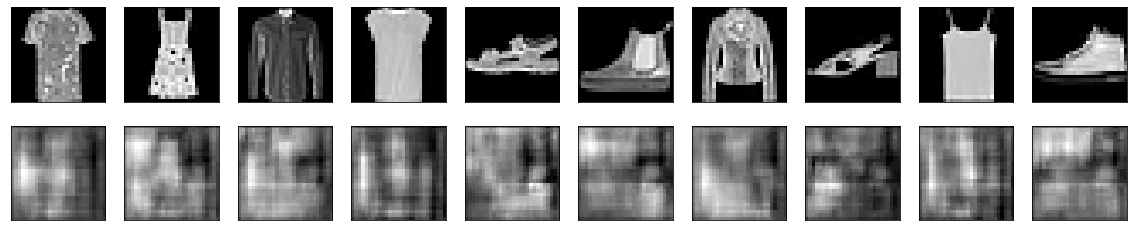

In [5]:
# Decode images and visualizations
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    i2 = random.randrange(0,10000)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i2].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i2].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The model blur the images but we can still see the general shapes in the images. 

## 2. Image Classification

### 2.1 Deep CNN

In [2]:
# load and preprocess fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))
# Convert to one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10)
print(y_train.shape)

(60000, 10)


In [3]:
cnn = Sequential()
cnn.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = "valid", 
                 activation = 'relu', input_shape = (28, 28, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = "valid", 
                 activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(32, activation= 'relu'))
cnn.add(Dense(10, activation = 'softmax'))
cnn.summary()

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [4]:
cnn.fit(x = x_train, y = y_train, epochs = 10, batch_size = 64, verbose = 1)

Epoch 1/10
60000/60000 [==============================] - 24s 394us/step - loss: 0.5920 - accuracy: 0.7865
Epoch 2/10
60000/60000 [==============================] - 24s 395us/step - loss: 0.3899 - accuracy: 0.8603
Epoch 3/10
60000/60000 [==============================] - 24s 407us/step - loss: 0.3460 - accuracy: 0.8745
Epoch 4/10
60000/60000 [==============================] - 26s 432us/step - loss: 0.3195 - accuracy: 0.8832
Epoch 5/10
60000/60000 [==============================] - 24s 401us/step - loss: 0.2983 - accuracy: 0.8913
Epoch 6/10
60000/60000 [==============================] - 24s 399us/step - loss: 0.2838 - accuracy: 0.8963
Epoch 7/10
60000/60000 [==============================] - 24s 405us/step - loss: 0.2701 - accuracy: 0.9013
Epoch 8/10
60000/60000 [==============================] - 24s 402us/step - loss: 0.2593 - accuracy: 0.9050
Epoch 9/10
60000/60000 [==============================] - 25s 422us/step - loss: 0.2508 - accuracy: 0.9078
Epoch 10/10
60000/60000 [============

In [5]:
cnn.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 149us/step


[0.274504270362854, 0.8989999890327454]

#### Model
* 2 convolutional layers with kernel size of (3, 3), strides (1, 1), valid padding

* 2 max polling layers

* 2 dense layers

#### Performance
* Loss on on Training set: 0.2452
* Accuracy on Training set: 90.96%
* Loss on on Test set: 0.2745
* Accuracy on Test set: 89.90%

### 2.2 Transfer Learning

In [37]:
# load and preprocess fashion MNIST dataset, convert grey-scale to rgb
def to_rgb(img):
    img = K.expand_dims(img, axis=-1)
    tiling = [1] * 4    
    tiling[-1] *= 3
    img = K.tile(img, tiling)
    return img
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
x_train1 = np.asarray([cv2.resize(x, (48,48)) for x in x_train])
x_test1 = np.asarray([cv2.resize(x, (48,48)) for x in x_test])
x_train1 = x_train1.reshape(x_train1.shape[0], 48, 48,1)
x_test1  = x_test1.reshape(x_test1.shape[0], 48, 48, 1)
# make gray images into rgb images
x_train1 = x_train1.repeat(3, axis=-1)
x_test1  = x_test1.repeat(3, axis=-1)

In [40]:
vgg = VGG16(weights="imagenet", include_top = False, input_shape = (48,48,3))
transfer = Sequential()
transfer.add(vgg)
transfer.add(Flatten())
transfer.add(Dense(256, activation="relu"))
transfer.add(Dropout(0.2))
transfer.add(Dense(10, activation="softmax"))   
vgg.trainable = False
transfer.summary()

transfer.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
transfer.fit(x_train1, y_train, batch_size=128, shuffle=True, epochs=5, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 1301s 24ms/step - loss: 0.5940 - accuracy: 0.7928 - val_loss: 0.4261 - val_accuracy: 0.8467
Epoch 2/5
54000/54000 [==============================] - 1259s 23ms/step - loss: 0.4131 - accuracy: 0.8513 - val_loss: 0.3846 - val_accuracy: 0.8613
Epoch 3/5
54000/54000 [==============================] - 1248s 23ms/step - loss: 0.3758 - accuracy: 0.8626 - val_loss: 0.3637 - val_accuracy: 0.8705
Epoch 4/5
54000/54000 [==============================] - 1232s 23ms/step - loss: 0.3514 - accuracy: 0.8718 - val_loss: 0.3476 - val_accuracy: 0.8765
Epoch 5/5
54000/54000 [==============================] - 1126s 21ms/step - loss: 0.3357 - accuracy: 0.8779 - val_loss: 0.3383 - val_accuracy: 0.8798


In [42]:
transfer.evaluate(x_test1, y_test)

10000/10000 [==============================] - 283s 28ms/step


[0.3578084618091583, 0.8736000061035156]

#### Model
* VGG16

* dense layer

#### Performance
* Loss on on Training set: 0.3357
* Accuracy on Training set: 87.79%
* Loss on on Validation set: 0.3383
* Accuracy on Validation set: 87.98%
* Loss on on Test set: 0.3578
* Accuracy on Test set: 87.36%

## 3. Text Classification

### 3.1 RNN (LSTM)

In [26]:
twt = pd.read_csv('tweets_with_labels.csv',sep='\t')
twt.head(5)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [46]:
# Clean tweets
preprocessor.set_options(preprocessor.OPT.URL, 
                         preprocessor.OPT.MENTION,
                         preprocessor.OPT.SMILEY,
                         preprocessor.OPT.RESERVED,
                         preprocessor.OPT.EMOJI)
def clean_tweet (t):  
    result = re.sub(r'[^a-zA-Z0-9\s]', ' ', preprocessor.clean(t))
    return result
twt['tweet2'] = [clean_tweet(t) for t in twt['tweet']]

In [47]:
twt.head(5)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweet2
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,Jazz for a Rainy Afternoon link
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,I love rainy days
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,Good Morning Chicago Time to kick the Windy C...
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0,Preach lol RT alliwantis this type of weat...
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0,good morning sunshine


In [55]:
# Prepare Tweets and Labels 
tweets = twt['tweet2']
labels = twt.iloc[:,2:-1].values
twt_train,twt_test,label_train,label_test = train_test_split(tweets,labels,test_size=0.3,random_state=1206)
MAX_NUM_WORDS = 300
MAX_SEQUENCE_LENGTH = 50 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(twt_train)
train_seq = tokenizer.texts_to_sequences(twt_train) 
test_seq = tokenizer.texts_to_sequences(twt_test)
twt_train2 = pad_sequences(train_seq,maxlen=MAX_SEQUENCE_LENGTH)
twt_test2 = pad_sequences(test_seq,maxlen=MAX_SEQUENCE_LENGTH)
# print(twt_train2.shape,twt_test2.shape)

In [66]:
# LSTM: RNN model
rnn = Sequential()
rnn.add(Embedding(MAX_NUM_WORDS, 64))
rnn.add(LSTM(32))
rnn.add(Dense(15, activation ='sigmoid'))
rnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
rnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          19200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_22 (Dense)             (None, 15)                495       
Total params: 32,111
Trainable params: 32,111
Non-trainable params: 0
_________________________________________________________________


In [67]:
rnn_history = rnn.fit(twt_train2, label_train,epochs = 10, validation_split = 0.1, batch_size = 64,verbose=1)

Train on 49105 samples, validate on 5457 samples
Epoch 1/10
49105/49105 [==============================] - 92s 2ms/step - loss: 0.1977 - accuracy: 0.8848 - val_loss: 0.1382 - val_accuracy: 0.9036
Epoch 2/10
49105/49105 [==============================] - 91s 2ms/step - loss: 0.1221 - accuracy: 0.9083 - val_loss: 0.1156 - val_accuracy: 0.9111
Epoch 3/10
49105/49105 [==============================] - 99s 2ms/step - loss: 0.1130 - accuracy: 0.9106 - val_loss: 0.1124 - val_accuracy: 0.9119
Epoch 4/10
49105/49105 [==============================] - 90s 2ms/step - loss: 0.1100 - accuracy: 0.9112 - val_loss: 0.1103 - val_accuracy: 0.9121
Epoch 5/10
49105/49105 [==============================] - 89s 2ms/step - loss: 0.1084 - accuracy: 0.9114 - val_loss: 0.1093 - val_accuracy: 0.9119
Epoch 6/10
49105/49105 [==============================] - 90s 2ms/step - loss: 0.1074 - accuracy: 0.9115 - val_loss: 0.1077 - val_accuracy: 0.9124
Epoch 7/10
49105/49105 [==============================] - 90s 2ms/ste

In [68]:
rnn.evaluate(twt_test2, label_test)

23384/23384 [==============================] - 17s 735us/step


[0.10661660905339887, 0.9117632508277893]

#### Performance
* Loss on on Training set: 0.1048
* Accuracy on Training set: 91.18%
* Loss on on Validation set: 0.1057
* Accuracy on Validation set: 91.25%
* Loss on on Test set: 0.1066
* Accuracy on Test set: 91.18%

### 3.2 CNN

In [70]:
cnn = Sequential()
cnn.add(Embedding(MAX_NUM_WORDS, 64))
cnn.add(Conv1D(64, kernel_size = 3, padding='valid', activation='relu', strides=1))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dropout(0.2))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(15, activation='softmax'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [72]:
cnn_history = cnn.fit(twt_train2, label_train, epochs = 10, validation_split = 0.1, batch_size = 64, verbose=1)

Train on 49105 samples, validate on 5457 samples
Epoch 1/10
49105/49105 [==============================] - 17s 340us/step - loss: 0.1086 - accuracy: 0.9092 - val_loss: 0.1057 - val_accuracy: 0.9099
Epoch 2/10
49105/49105 [==============================] - 18s 371us/step - loss: 0.1080 - accuracy: 0.9092 - val_loss: 0.1059 - val_accuracy: 0.9100
Epoch 3/10
49105/49105 [==============================] - 17s 350us/step - loss: 0.1075 - accuracy: 0.9092 - val_loss: 0.1059 - val_accuracy: 0.9099
Epoch 4/10
49105/49105 [==============================] - 17s 354us/step - loss: 0.1071 - accuracy: 0.9093 - val_loss: 0.1063 - val_accuracy: 0.9095
Epoch 5/10
49105/49105 [==============================] - 17s 354us/step - loss: 0.1067 - accuracy: 0.9093 - val_loss: 0.1069 - val_accuracy: 0.9096
Epoch 6/10
49105/49105 [==============================] - 17s 354us/step - loss: 0.1066 - accuracy: 0.9094 - val_loss: 0.1070 - val_accuracy: 0.9096
Epoch 7/10
49105/49105 [==============================] -

In [73]:
cnn.evaluate(twt_test2, label_test)

23384/23384 [==============================] - 3s 113us/step


[0.11062558209686055, 0.9088779091835022]

#### Performance
* Loss on on Training set: 0.1053
* Accuracy on Training set: 90.94%
* Loss on on Validation set: 0.1075
* Accuracy on Validation set: 90.95%
* Loss on on Test set: 0.1106
* Accuracy on Test set: 90.89%

### 3.3 Comparison

#### Metric 1: Accuracy

In [74]:
accuracy_comparison = {'Training Set':[0.9118, 0.9094], 'Validation Set':[0.9125, 0.9095], 'Testing Set':[0.9118, 0.9089]}
pd.DataFrame(accuracy_comparison, index = ["RNN (LSTM)", "CNN"]) 

,Training Set,Validation Set,Testing Set
RNN (LSTM),0.9118,0.9125,0.9118
CNN,0.9094,0.9095,0.9089


By observing the accuracy, the performance of LSTM model is a little bit better than that of CNN.

#### Metric 2: ROC

In [150]:
# Convert labels to binary label
true_label = pd.DataFrame(label_test)
label_test2 = [np.argmax(np.array(true_label.iloc[i])) for i in range(len(true_label))]
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(label_test2)
label_test3 = lb.transform(label_test2)

In [154]:
# Predict using rnn and cnn models built
rnn_label_pred = rnn.predict(twt_test2)
cnn_label_pred = cnn.predict(twt_test2)

In [160]:
# fpr, tpr and thresholds
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(label_test3.ravel(), rnn_label_pred.ravel())
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(label_test3.ravel(), cnn_label_pred.ravel())

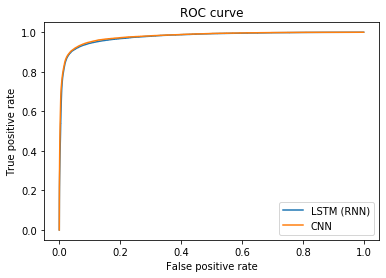

In [162]:
# ROC curve
plt.figure(1)
plt.plot(rnn_fpr, rnn_tpr, label='LSTM (RNN)')
plt.plot(cnn_fpr, cnn_tpr, label='CNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

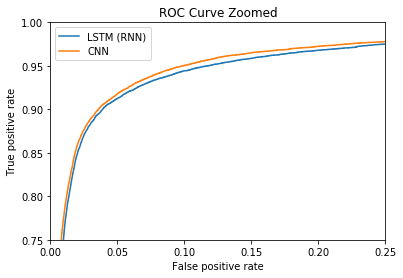

In [165]:
# Zoomed Version
plt.figure(1)
plt.xlim(0, 0.25)
plt.ylim(.75, 1)
plt.plot(rnn_fpr, rnn_tpr, label='LSTM (RNN)')
plt.plot(cnn_fpr, cnn_tpr, label='CNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve Zoomed')
plt.legend()
plt.show()

From the ROC plot, we can see CNN model's ROC is slight better than LSTM model's ROC.